# Project: Soccer data analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> In this document we are going to investigate a Soccer database in which we have information about nine european countries and their corresponding leagues. This database contains, among others, odd information, results of the matches, scored goals, season, etc. Our target will be to analyze the odds related to the results (if winner was local or not and favourite or non-favourite) and the goal difference and compare between different countries and seasons in order to get information about result and betting trends.

In [442]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline 


con = sqlite3.connect("soccer.sqlite")

df_country = pd.read_sql_query("SELECT *from Country", con) # We read the 'Country' table of the database
df_league = pd.read_sql_query("SELECT *from League", con) # We read the 'League' table of the database
df_match = pd.read_sql_query("SELECT *from Match", con) # We read the 'Match' table of the database
df_player = pd.read_sql_query("SELECT *from Player", con) # We read the 'Player' table of the database
df_player_attr = pd.read_sql_query("SELECT *from Player_Attributes", con) # We read the 'Player_Attributes' table of the database
df_team = pd.read_sql_query("SELECT *from Team", con) # We read the 'Team' table of the database
df_team_attr = pd.read_sql_query("SELECT *from Team_Attributes", con) # We read the 'Team_Attributes' table of the database
df_sequence = pd.read_sql_query("SELECT *from sqlite_sequence", con) # We read the 'sqlite_sequence' table of the database

We are going to extract the data from SQL database and create the required dataframes

<a id='wrangling'></a>
## Data Wrangling

> Here we are going to work the database to be handy and more efficient to work with later in the exploratory analysis.

### General Properties
First of all we are going to check the information of each dataframe.

In [443]:
df_country.head(2)

,id,name
0,1,Belgium
1,1729,England


In [444]:
df_league.head(2)

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League


In [445]:
df_cleague=pd.merge(df_league, df_country,how='inner',on=['id']) 
df_cleague

,id,country_id,name_x,name_y
0,1,1,Belgium Jupiler League,Belgium
1,1729,1729,England Premier League,England
2,4769,4769,France Ligue 1,France
3,7809,7809,Germany 1. Bundesliga,Germany
4,10257,10257,Italy Serie A,Italy
5,13274,13274,Netherlands Eredivisie,Netherlands
6,15722,15722,Poland Ekstraklasa,Poland
7,17642,17642,Portugal Liga ZON Sagres,Portugal
8,19694,19694,Scotland Premier League,Scotland
9,21518,21518,Spain LIGA BBVA,Spain


We are going to merge the country and league dataframes by joining the 'id' column innerly. This way we will know the league name in each country

In [446]:
df_cleague.rename(columns={'name_x':'league_name','name_y':'country'},inplace=True)
df_cleague.head(2)

,id,country_id,league_name,country
0,1,1,Belgium Jupiler League,Belgium
1,1729,1729,England Premier League,England


We have changed the column names to directly specify which column belongs to the country and which to the league name.

In [447]:
df_match.rename(columns={'match_api_id':'match'},inplace=True)
df_match.head(2)

,id,country_id,league_id,season,stage,date,match,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.0,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.2
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.8,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.6


The column 'match_api_id' name has been changed for 'match' name

In [448]:
df_odd=df_match.iloc[:,np.r_[6,85:115]] 
df_odd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   match   25979 non-null  int64  
 1   B365H   22592 non-null  float64
 2   B365D   22592 non-null  float64
 3   B365A   22592 non-null  float64
 4   BWH     22575 non-null  float64
 5   BWD     22575 non-null  float64
 6   BWA     22575 non-null  float64
 7   IWH     22520 non-null  float64
 8   IWD     22520 non-null  float64
 9   IWA     22520 non-null  float64
 10  LBH     22556 non-null  float64
 11  LBD     22556 non-null  float64
 12  LBA     22556 non-null  float64
 13  PSH     11168 non-null  float64
 14  PSD     11168 non-null  float64
 15  PSA     11168 non-null  float64
 16  WHH     22571 non-null  float64
 17  WHD     22571 non-null  float64
 18  WHA     22571 non-null  float64
 19  SJH     17097 non-null  float64
 20  SJD     17097 non-null  float64
 21  SJA     17097 non-null  float64
 22

We have created dataframe containing just the betting odds and the match, so we can identify the corresponding odd for each match.

In [449]:
df_odd=df_odd.dropna(thresh=3) 
df_odd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22597 entries, 0 to 24556
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   match   22597 non-null  int64  
 1   B365H   22592 non-null  float64
 2   B365D   22592 non-null  float64
 3   B365A   22592 non-null  float64
 4   BWH     22575 non-null  float64
 5   BWD     22575 non-null  float64
 6   BWA     22575 non-null  float64
 7   IWH     22520 non-null  float64
 8   IWD     22520 non-null  float64
 9   IWA     22520 non-null  float64
 10  LBH     22556 non-null  float64
 11  LBD     22556 non-null  float64
 12  LBA     22556 non-null  float64
 13  PSH     11168 non-null  float64
 14  PSD     11168 non-null  float64
 15  PSA     11168 non-null  float64
 16  WHH     22571 non-null  float64
 17  WHD     22571 non-null  float64
 18  WHA     22571 non-null  float64
 19  SJH     17097 non-null  float64
 20  SJD     17097 non-null  float64
 21  SJA     17097 non-null  float64
 22

We delete the rows, where the amount of values different to NaN is less than 3.

In [450]:
df_odd.head()

,match,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,492473,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.2,3.5,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,492474,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.2,3.5,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,492475,2.38,3.30,2.75,2.40,3.30,2.55,2.60,3.1,2.3,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,492476,1.44,3.75,7.50,1.40,4.00,6.80,1.40,3.9,6.0,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,492477,5.00,3.50,1.65,5.00,3.50,1.60,4.00,3.3,1.7,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [451]:
subset_h = df_odd.loc[:,['BWH','B365H','IWH','LBH','PSH','WHH','SJH','VCH','GBH','BSH']]# subset for the home odds
subset_d = df_odd.loc[:,['BWD','B365D','IWD','LBD','PSD','WHD','SJD','VCD','GBD','BSD']]# subset for even odds
subset_a = df_odd.loc[:,['BWA','B365A','IWA','LBA','PSA','WHA','SJA','VCA','GBA','BSA']]# subset for away odds


df_odd['mean_oddh'] = subset_h.mean(axis=1)# we create the mean value of all the odds, home, even and away winner.
df_odd['mean_oddd'] = subset_d.mean(axis=1)
df_odd['mean_odda'] = subset_a.mean(axis=1)


df_odd.head()

,match,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,...,VCA,GBH,GBD,GBA,BSH,BSD,BSA,mean_oddh,mean_oddd,mean_odda
0,492473,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.2,3.5,...,4.50,1.78,3.25,4.00,1.73,3.40,4.20,1.765556,3.322222,4.164444
1,492474,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.2,3.5,...,3.25,1.85,3.25,3.75,1.91,3.25,3.60,1.898889,3.250000,3.616667
2,492475,2.38,3.30,2.75,2.40,3.30,2.55,2.60,3.1,2.3,...,2.65,2.50,3.20,2.50,2.30,3.20,2.75,2.462222,3.233333,2.544444
3,492476,1.44,3.75,7.50,1.40,4.00,6.80,1.40,3.9,6.0,...,6.50,1.50,3.75,5.50,1.44,3.75,6.50,1.438889,3.805556,6.533333
4,492477,5.00,3.50,1.65,5.00,3.50,1.60,4.00,3.3,1.7,...,1.65,4.50,3.50,1.65,4.75,3.30,1.67,4.494444,3.422222,1.674444


We have created three different substets with the odds corresponding to home winner, even and away winner. After this, we have calculated
the mean of each of these odds and we have created the corresponding column in the *df_odd* dataframe. Now we have a dataframe which includes the betting odds and the overall mean for home, even and away.

In [452]:
df_mean_odds = df_odd.iloc[:,np.r_[0,31,32,33]]

The **df_mean_odds** dataframe just includes the match id and the mean odds. From now on, we will work with these mean values.

In [453]:
df_mean_odds.head(2)

,match,mean_oddh,mean_oddd,mean_odda
0,492473,1.765556,3.322222,4.164444
1,492474,1.898889,3.250000,3.616667


In [454]:
df_mean_odds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22597 entries, 0 to 24556
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   match      22597 non-null  int64  
 1   mean_oddh  22597 non-null  float64
 2   mean_oddd  22597 non-null  float64
 3   mean_odda  22597 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 882.7 KB


In [455]:
df_match.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Columns: 115 entries, id to BSA
dtypes: float64(96), int64(9), object(10)
memory usage: 22.8+ MB


In [456]:
df_league_match=pd.merge(df_match, df_cleague,how='inner',on=['country_id']) 
df_league_match.head(2)

,id_x,country_id,league_id,season,stage,date,match,home_team_api_id,away_team_api_id,home_team_goal,...,VCA,GBH,GBD,GBA,BSH,BSD,BSA,id_y,league_name,country
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.50,1.78,3.25,4.00,1.73,3.40,4.2,1,Belgium Jupiler League,Belgium
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.25,1.85,3.25,3.75,1.91,3.25,3.6,1,Belgium Jupiler League,Belgium


We merge the *df_match* dataframe with the *df_cleague* innerly in order to be able to calculate the goal difference in every match.

In [457]:
df_league_match['goal_diff'] = df_league_match.apply(lambda row: row.home_team_goal - row.away_team_goal, axis=1) 
df_league_match.head(1)

,id_x,country_id,league_id,season,stage,date,match,home_team_api_id,away_team_api_id,home_team_goal,...,GBH,GBD,GBA,BSH,BSD,BSA,id_y,league_name,country,goal_diff
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,1.78,3.25,4.0,1.73,3.4,4.2,1,Belgium Jupiler League,Belgium,0


Now we create a column called *goal_diff*. This way, we can determine if the team who played at home won 
(if the result is greater than zero), if the match was even (if result equal zero) or if the away team won, when the result is
a negative integer.

In [458]:
def resultado(row):
    if row['goal_diff']==0:
        return 'Even'
    elif row['goal_diff']>=1:
        return 'Local_won'
    else:
        return 'Visit_won'
    
df_league_match['result']=df_league_match.apply(lambda row: resultado(row),axis=1)
df_league_match.head(2)

,id_x,country_id,league_id,season,stage,date,match,home_team_api_id,away_team_api_id,home_team_goal,...,GBD,GBA,BSH,BSD,BSA,id_y,league_name,country,goal_diff,result
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,3.25,4.00,1.73,3.40,4.2,1,Belgium Jupiler League,Belgium,0,Even
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.25,3.75,1.91,3.25,3.6,1,Belgium Jupiler League,Belgium,0,Even


Now we create a new column, called *result* to put into words what immediately before was explained,
so we now if the result was a *Victory*, *Even* or a *Defeat*, always talking of the point of view of the home team.

In [459]:
df_league_match.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25979 entries, 0 to 25978
Columns: 120 entries, id_x to result
dtypes: float64(96), int64(11), object(13)
memory usage: 24.0+ MB


In [460]:
df_league_match=df_league_match.iloc[:,np.r_[2,3,6,116,117,118,119]]

The next step will be to choose the columns that will be usefult later, in order to merge the new dataframe with the 
*df_mean_odds* one.

In [461]:
df_league_match.head(1)

,league_id,season,match,league_name,country,goal_diff,result
0,1,2008/2009,492473,Belgium Jupiler League,Belgium,0,Even


In [462]:
df_league_match.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25979 entries, 0 to 25978
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   league_id    25979 non-null  int64 
 1   season       25979 non-null  object
 2   match        25979 non-null  int64 
 3   league_name  25979 non-null  object
 4   country      25979 non-null  object
 5   goal_diff    25979 non-null  int64 
 6   result       25979 non-null  object
dtypes: int64(3), object(4)
memory usage: 1.6+ MB


In [463]:
sum(df_league_match.T.duplicated().T) 

0

To check if duplicated columns

In [464]:
sum(df_league_match.duplicated()) 

0

To check if duplicated rows

In [465]:
df_stats = pd.merge(df_league_match, df_mean_odds,how='inner',on=['match'])
df_stats

,league_id,season,match,league_name,country,goal_diff,result,mean_oddh,mean_oddd,mean_odda
0,1,2008/2009,492473,Belgium Jupiler League,Belgium,0,Even,1.765556,3.322222,4.164444
1,1,2008/2009,492474,Belgium Jupiler League,Belgium,0,Even,1.898889,3.250000,3.616667
2,1,2008/2009,492475,Belgium Jupiler League,Belgium,-3,Visit_won,2.462222,3.233333,2.544444
3,1,2008/2009,492476,Belgium Jupiler League,Belgium,5,Local_won,1.438889,3.805556,6.533333
4,1,2008/2009,492477,Belgium Jupiler League,Belgium,-2,Visit_won,4.494444,3.422222,1.674444
...,...,...,...,...,...,...,...,...,...,...
22592,21518,2015/2016,2030167,Spain LIGA BBVA,Spain,1,Local_won,1.590000,3.800000,6.494286
22593,21518,2015/2016,2030168,Spain LIGA BBVA,Spain,2,Local_won,2.298571,3.230000,3.258571
22594,21518,2015/2016,2030169,Spain LIGA BBVA,Spain,3,Local_won,1.550000,3.958571,6.621429
22595,21518,2015/2016,2030170,Spain LIGA BBVA,Spain,0,Even,2.341429,3.271429,3.121429


We make a *merge* with the above mentioned two dataframes. With this information we will determine wether the favourite
team won the match or not.

In [466]:
df_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22597 entries, 0 to 22596
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   league_id    22597 non-null  int64  
 1   season       22597 non-null  object 
 2   match        22597 non-null  int64  
 3   league_name  22597 non-null  object 
 4   country      22597 non-null  object 
 5   goal_diff    22597 non-null  int64  
 6   result       22597 non-null  object 
 7   mean_oddh    22597 non-null  float64
 8   mean_oddd    22597 non-null  float64
 9   mean_odda    22597 non-null  float64
dtypes: float64(3), int64(3), object(4)
memory usage: 1.9+ MB


In [467]:
def favorito(row):
    if row['result']=='Local_won' and row['mean_oddh']<row['mean_odda']:
        return 'Favourite_won'
    elif row['result']=='Visit_won' and row['mean_oddh']<row['mean_odda']:
        return 'Non_favourite_won'
    elif row['result']=='Visit_won' and row['mean_oddh']>row['mean_odda']:
        return 'Favourite_won'
    elif row['result']=='Local_won' and row['mean_oddh']>row['mean_odda']:
        return 'Non_favourite_won'
    
    else:
        return 'No_winner'
    
df_stats['favourite']=df_stats.apply(lambda row: favorito(row),axis=1)
df_stats.head()

,league_id,season,match,league_name,country,goal_diff,result,mean_oddh,mean_oddd,mean_odda,favourite
0,1,2008/2009,492473,Belgium Jupiler League,Belgium,0,Even,1.765556,3.322222,4.164444,No_winner
1,1,2008/2009,492474,Belgium Jupiler League,Belgium,0,Even,1.898889,3.250000,3.616667,No_winner
2,1,2008/2009,492475,Belgium Jupiler League,Belgium,-3,Visit_won,2.462222,3.233333,2.544444,Non_favourite_won
3,1,2008/2009,492476,Belgium Jupiler League,Belgium,5,Local_won,1.438889,3.805556,6.533333,Favourite_won
4,1,2008/2009,492477,Belgium Jupiler League,Belgium,-2,Visit_won,4.494444,3.422222,1.674444,Favourite_won


Taking into account the odd values and the results, we will create a new column called *favourite* to state if the favourite 
(team for which the odd has the lowest value) team won or not.

<a id='eda'></a>
## Exploratory Data Analysis


### Question 1: Which is the absolute result proportion and the proportion by country?

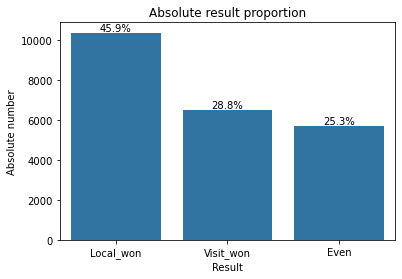

In [468]:
count_results = df_stats['result'].value_counts()
order=count_results.index
base_color = sb.color_palette()[0]
sb.countplot(data=df_stats, x='result', color=base_color, order=order);

locs, labels = plt.xticks(rotation=0) 

for loc, label in zip(locs, labels):

    count = count_results[label.get_text()]
    pct_string = '{:0.1f}%'.format(100*count/df_stats.shape[0])

    
    plt.text(loc, count+100, pct_string, ha = 'center', color = 'black')
    plt.ylabel('Absolute number')
    plt.xlabel('Result')
    plt.title('Absolute result proportion')

In this bar chart we can see the absolute number of victories, defeats and even matches in the y axis from all over the world and the corresponding percentage on top of the bars, values from 2008 to 2016 are taken into account.

In [469]:
tot_vict = (df_stats[df_stats['result']=='Local_won'].shape[0]/df_stats.shape[0])*100
tot_vict

45.90874894897553

Almost the 46% of victories were fot the team that played as local.

In [470]:
tot_even = (df_stats[df_stats['result']=='Even'].shape[0]/df_stats.shape[0])*100
tot_even

25.304243926184895

The 25% of the matches were even.

In [471]:
tot_def = (df_stats[df_stats['result']=='Visit_won'].shape[0]/df_stats.shape[0])*100
tot_def

28.78700712483958

Only the 28,7% of the matches were won by the team that played away

In [472]:
rslt_cntry = pd.DataFrame({'percent' : df_stats.groupby(['country','season']).result.value_counts(normalize = True)}).reset_index()
rslt_cntry['percent']=rslt_cntry['percent']*100
rslt_cntry.head(1)

,country,season,result,percent
0,Belgium,2008/2009,Local_won,48.844884


In [473]:
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('medium')

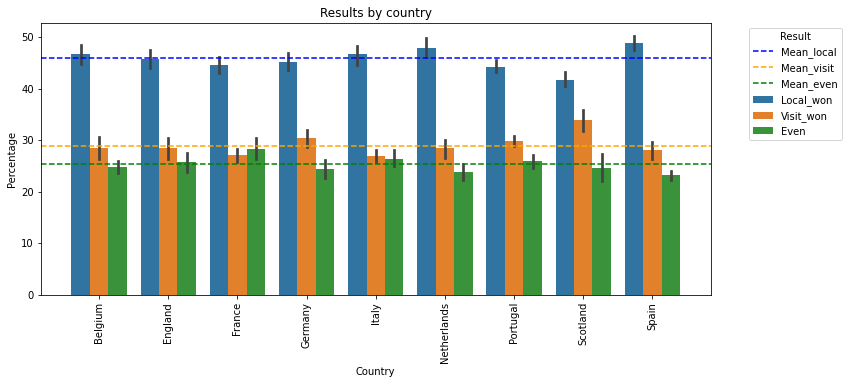

In [474]:
plt.figure(figsize=(12,5))
ax = sb.barplot(data = rslt_cntry, x = 'country', y = 'percent', hue = 'result')
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Percentage')
plt.axhline(y = tot_vict, color = 'b', linestyle = '--') 
plt.axhline(y = tot_def, color = 'orange', linestyle = 'dashed')
plt.axhline(y = tot_even, color = 'green', linestyle = 'dashed')
mean_line_v= ax.plot(tot_vict, label='Mean_local', linestyle='--', color='b')
mean_line_d= ax.plot(tot_def, label='Mean_visit', linestyle='--',color='orange')
mean_line_e=ax.plot(tot_even, label='Mean_even', linestyle='--',color='green')
plt.title('Results by country')
ax.legend(title = 'Result', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
plt.show()

As we can see in the plot above, the most common result is the victory of the local team followed by the defeat of the same
team. The least result that happens is an even. In addition, the plot shows that Spain is the country where most local victories take place and the least number of visiting team victories happen. On the other hand, France is the country where the away team has the hight victories percentage. Finally, we can see that Scotland is the country with the hightest even rate.

### Question 2: Where do the teams with lowest betting odds (considered favourite teams) win most matches? And those with hightest betting odds (considered non-favourite teams)?

In [475]:
tot_fav = (df_stats[df_stats['favourite']=='Favourite_won'].shape[0]/df_stats.shape[0])*100
tot_fav

53.201752445014826

In [476]:
tot_nonfav = (df_stats[df_stats['favourite']=='Non_favourite_won'].shape[0]/df_stats.shape[0])*100
tot_nonfav

21.485152896402177

In [477]:
tot_nonwin = (df_stats[df_stats['favourite']=='No_winner'].shape[0]/df_stats.shape[0])*100
tot_nonwin

25.313094658582997

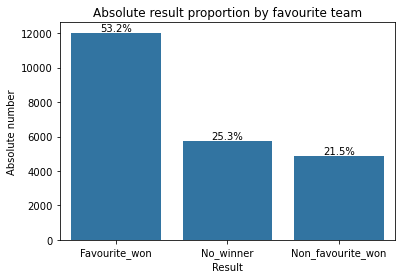

In [478]:
count_favourite = df_stats['favourite'].value_counts()
order_fav=count_favourite.index
base_color = sb.color_palette()[0]
sb.countplot(data=df_stats, x='favourite', color=base_color, order=order_fav);

locs, labels = plt.xticks(rotation=0) 

for loc, label in zip(locs, labels):

    count = count_favourite[label.get_text()]
    pct_string = '{:0.1f}%'.format(100*count/df_stats.shape[0])

    
    plt.text(loc, count+100, pct_string, ha = 'center', color = 'black')
    plt.ylabel('Absolute number')
    plt.xlabel('Result')
    plt.title('Absolute result proportion by favourite team')

In the bar plot above we can see the results dependind on the betting odds. The favourite team won more the half of the matches
and the team with the highest betting odd (non-favourite team) won just the 21,5% of the games.

In [479]:
fav_cntry = pd.DataFrame({'percent' : df_stats.groupby(['country','season']).favourite.value_counts(normalize = True)}).reset_index()
fav_cntry['percent']=fav_cntry['percent']*100
fav_cntry.head(2)

,country,season,favourite,percent
0,Belgium,2008/2009,Favourite_won,53.795380
1,Belgium,2008/2009,Non_favourite_won,24.422442


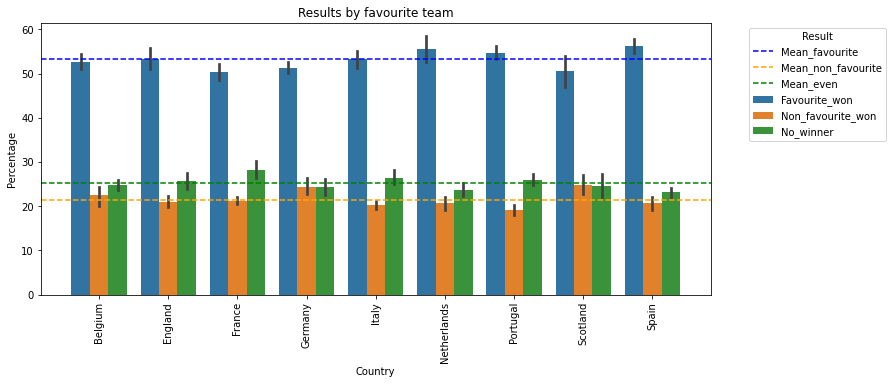

In [480]:
plt.figure(figsize=(12,5))
ax = sb.barplot(data = fav_cntry, x = 'country', y = 'percent', hue = 'favourite')
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Percentage')
plt.axhline(y = tot_fav, color = 'b', linestyle = '--') 
plt.axhline(y = tot_nonfav, color = 'orange', linestyle = 'dashed')
plt.axhline(y = tot_nonwin, color = 'green', linestyle = 'dashed')
mean_line_f= ax.plot(tot_fav, label='Mean_favourite', linestyle='--', color='b')
mean_line_nf= ax.plot(tot_nonfav, label='Mean_non_favourite', linestyle='--',color='orange')
mean_line_e=ax.plot(tot_even, label='Mean_even', linestyle='--',color='green')
plt.title('Results by favourite team')
ax.legend(title = 'Result', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
plt.show()

In [481]:
fav_cntry.groupby(['country','favourite']).percent.mean()


country      favourite        
Belgium      Favourite_won        52.742897
             No_winner            24.782334
             Non_favourite_won    22.474770
England      Favourite_won        53.289474
             No_winner            25.756579
             Non_favourite_won    20.953947
France       Favourite_won        50.442473
             No_winner            28.286002
             Non_favourite_won    21.271525
Germany      Favourite_won        51.286832
             No_winner            24.397702
             Non_favourite_won    24.315467
Italy        Favourite_won        53.302388
             No_winner            26.392442
             Non_favourite_won    20.305170
Netherlands  Favourite_won        55.583414
             No_winner            23.721606
             Non_favourite_won    20.694980
Portugal     Favourite_won        54.712396
             No_winner            26.045020
             Non_favourite_won    19.242584
Scotland     Favourite_won        50.603070
 

The last bar plot shows the distribuiton of results by country and favourite team. The more predictable results for the favourite team victory take place in Spain and Netherlands and so it is for the non-favourite teams, where the trend is the same, the least percentage of victories is the lowest also for Spain and Netherlands. 

### Question 3: Which is the goal difference by country when the favourite team wins or whe the non-favourite team wins, depending if they play as local or away?

In [482]:
df_statsv=df_stats[df_stats['favourite']=='Favourite_won']
df_statsv['goal_diff_abs']=df_stats['goal_diff'].abs()
df_statsv.head()

<ipython-input-482-0fb6b700d525>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_statsv['goal_diff_abs']=df_stats['goal_diff'].abs()


,league_id,season,match,league_name,country,goal_diff,result,mean_oddh,mean_oddd,mean_odda,favourite,goal_diff_abs
3,1,2008/2009,492476,Belgium Jupiler League,Belgium,5,Local_won,1.438889,3.805556,6.533333,Favourite_won,5
4,1,2008/2009,492477,Belgium Jupiler League,Belgium,-2,Visit_won,4.494444,3.422222,1.674444,Favourite_won,2
7,1,2008/2009,492480,Belgium Jupiler League,Belgium,-1,Visit_won,2.714444,3.272222,2.316667,Favourite_won,1
8,1,2008/2009,492481,Belgium Jupiler League,Belgium,1,Local_won,2.222222,3.233333,2.842222,Favourite_won,1
9,1,2008/2009,492564,Belgium Jupiler League,Belgium,3,Local_won,1.284444,4.666667,9.111111,Favourite_won,3


*df_statsd* is the dataframe for the matches that **favourite** team won

In [483]:
mean1=df_statsv[df_statsv['result']=='Local_won']
mean_loc1=mean1['goal_diff_abs'].mean()
mean2=df_statsv[df_statsv['result']=='Visit_won']
mean_loc2=mean2['goal_diff_abs'].mean()
mean_loc1, mean_loc2

(1.9719783929777177, 1.8887117346938775)

Above we can see the mean on the difference on goals when the favourite team wins, depending if it plays home or away.

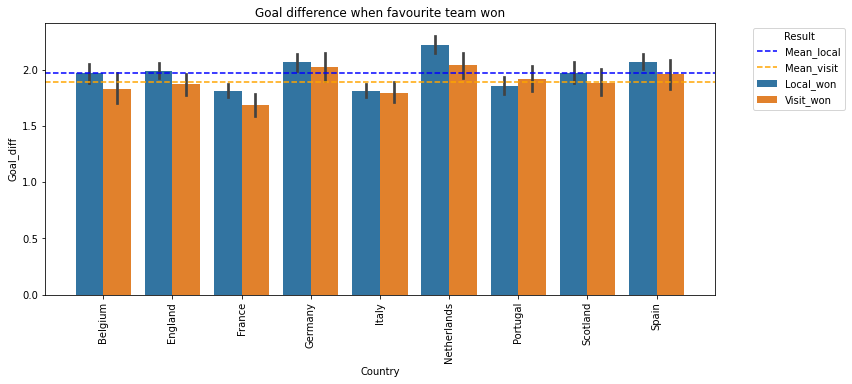

In [484]:
plt.figure(figsize=(12,5))
ax = sb.barplot(data = df_statsv, x = 'country', y = 'goal_diff_abs', hue = 'result')
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Goal_diff')
mean_line1= ax.plot(mean_loc1, label='Mean_local', linestyle='--', color='blue')
mean_line2= ax.plot(mean_loc2, label='Mean_visit', linestyle='--',color='orange')
plt.axhline(y = mean_loc1, color = 'blue', linestyle = '--') 
plt.axhline(y = mean_loc2, color = 'orange', linestyle = 'dashed')

plt.title('Goal difference when favourite team won')
ax.legend(title = 'Result', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
plt.show()

We have both calculated and made the visualization for the mean value of the goal difference when the favourite team wins. After that we compare this average values with the corresponding values by country. This way we can see that the greatest goal difference both for local and away victories take place in Netherlands, followed by Spain.

In [485]:
df_statsd=df_stats[df_stats['favourite']=='Non_favourite_won']
df_statsd['goal_diff_abs']=df_stats['goal_diff'].abs()
df_statsd.head()

<ipython-input-485-8729e6c10a2c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_statsd['goal_diff_abs']=df_stats['goal_diff'].abs()


,league_id,season,match,league_name,country,goal_diff,result,mean_oddh,mean_oddd,mean_odda,favourite,goal_diff_abs
2,1,2008/2009,492475,Belgium Jupiler League,Belgium,-3,Visit_won,2.462222,3.233333,2.544444,Non_favourite_won,3
10,1,2008/2009,492565,Belgium Jupiler League,Belgium,-1,Visit_won,1.271111,4.753333,9.277778,Non_favourite_won,1
14,1,2008/2009,492569,Belgium Jupiler League,Belgium,-1,Visit_won,1.707778,3.361111,4.342222,Non_favourite_won,1
15,1,2008/2009,492570,Belgium Jupiler League,Belgium,-1,Visit_won,2.266667,3.222222,2.831111,Non_favourite_won,1
18,1,2008/2009,492573,Belgium Jupiler League,Belgium,-1,Visit_won,1.308889,4.488889,8.277778,Non_favourite_won,1


*df_statsd* is the dataframe for the matches that **non-favourite** team won

In [486]:
mean3=df_statsd[df_statsd['result']=='Local_won']
mean_loc3=mean3['goal_diff_abs'].mean()
mean4=df_statsd[df_statsd['result']=='Visit_won']
mean_vis4=mean4['goal_diff_abs'].mean()
mean_loc3, mean_vis4

(1.5282637954239569, 1.543484713564856)

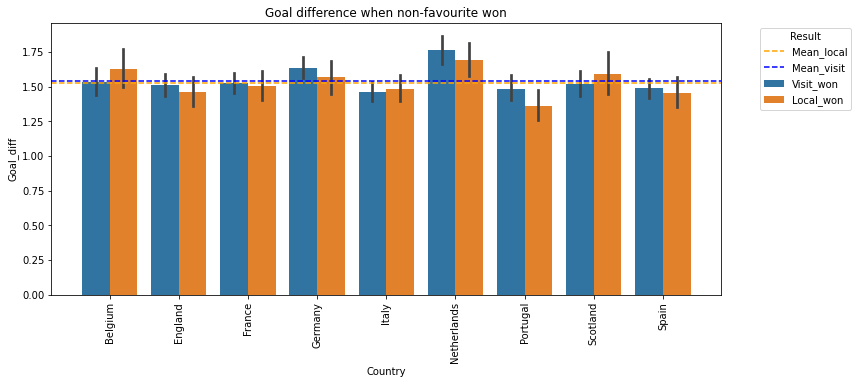

In [487]:
plt.figure(figsize=(12,5))
ax = sb.barplot(data = df_statsd, x = 'country', y = 'goal_diff_abs', hue = 'result')
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Goal_diff')
mean_lineloc3=ax.plot(mean_loc3, label='Mean_local', linestyle='--', color='orange')
mean_linevis4= ax.plot(mean_vis4, label='Mean_visit', linestyle='--',color='blue')
plt.axhline(y = mean_loc3, color = 'orange', linestyle = '--') 
plt.axhline(y = mean_vis4, color = 'blue', linestyle = 'dashed')
plt.title('Goal difference when non-favourite won')
ax.legend(title = 'Result', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
plt.show()

Regarding the previous plot, we can say that the goal difference is smaller for non-favourite victories than for favourite victories. However, the greatest goal difference happens to be again in Netherlands, followed by Germany, Scotland and Belgium.

### Question 4: Which is the goal difference by country when the favourite team wins or whe the non-favourite team wins, depending if they play as local or away?

In [488]:
df_statsv['fav_odd']=df_statsv[['mean_oddh','mean_odda']].min(axis=1)
df_statsv['non_fav_odd']=df_statsv[['mean_oddh','mean_odda']].max(axis=1)
df_statsd['non_fav_odd']=df_statsd[['mean_oddh','mean_odda']].max(axis=1)
df_statsd['fav_odd']=df_statsd[['mean_oddh','mean_odda']].min(axis=1)

<ipython-input-488-95f4cb80a72e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_statsv['fav_odd']=df_statsv[['mean_oddh','mean_odda']].min(axis=1)
<ipython-input-488-95f4cb80a72e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_statsv['non_fav_odd']=df_statsv[['mean_oddh','mean_odda']].max(axis=1)
<ipython-input-488-95f4cb80a72e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

We have created a new dataframe wiht a new column for the odds when the favourite team won and another dataframe for the non-favourite team´s victories, with the corresponding betting odd.

In [489]:
df_statsv.head(1) 

,league_id,season,match,league_name,country,goal_diff,result,mean_oddh,mean_oddd,mean_odda,favourite,goal_diff_abs,fav_odd,non_fav_odd
3,1,2008/2009,492476,Belgium Jupiler League,Belgium,5,Local_won,1.438889,3.805556,6.533333,Favourite_won,5,1.438889,6.533333


In [490]:
df_statsv['fav_odd'].mean(), df_statsv['fav_odd'].std()

(1.8054432740042723, 0.4192621454848486)

We calculate the average odd and the standard deviation when the favourite team won.

In [491]:
df_statsv['fav_odd'].max(), df_statsv['fav_odd'].min()

(3.9549999999999996, 1.03)

The maximum betting odd for a favourite team that won was 3.95 and the minimum one was 1.03

This is the mean odd for the matches in which the favourite team won.

In [492]:
df_statsv.groupby(['season', 'country']).fav_odd.mean()

season     country    
2008/2009  Belgium        1.752943
           England        1.790540
           France         1.937885
           Germany        1.816125
           Italy          1.840231
                            ...   
2015/2016  Italy          1.813197
           Netherlands    1.759718
           Portugal       1.738532
           Scotland       1.885990
           Spain          1.727947
Name: fav_odd, Length: 71, dtype: float64

Here we have calculated the mean values of the odds for favourite teams that won, by country and season.

In [493]:
df_statsd.head(1)

,league_id,season,match,league_name,country,goal_diff,result,mean_oddh,mean_oddd,mean_odda,favourite,goal_diff_abs,non_fav_odd,fav_odd
2,1,2008/2009,492475,Belgium Jupiler League,Belgium,-3,Visit_won,2.462222,3.233333,2.544444,Non_favourite_won,3,2.544444,2.462222


In [494]:
df_statsd['non_fav_odd'].mean(), df_statsd['non_fav_odd'].std()

(4.05241407728899, 1.8598778036433743)

We calculate the average odd and the standard deviation when non-favourite won.

In [495]:
df_statsd['non_fav_odd'].max(), df_statsd['non_fav_odd'].min()

(27.004285714285714, 2.488888888888889)

The maximum betting odd for a favourite team that won was 27 and the minimum one was 2.48

In [496]:
df_statsv.groupby(['season', 'country']).non_fav_odd.mean()

season     country    
2008/2009  Belgium        5.247626
           England        5.926656
           France         4.676007
           Germany        4.982403
           Italy          5.264549
                            ...   
2015/2016  Italy          6.192295
           Netherlands    5.634049
           Portugal       7.658708
           Scotland       5.541484
           Spain          8.377548
Name: non_fav_odd, Length: 71, dtype: float64

Here we have calculated the mean values of the odds for non-favourite that won, by country and season.

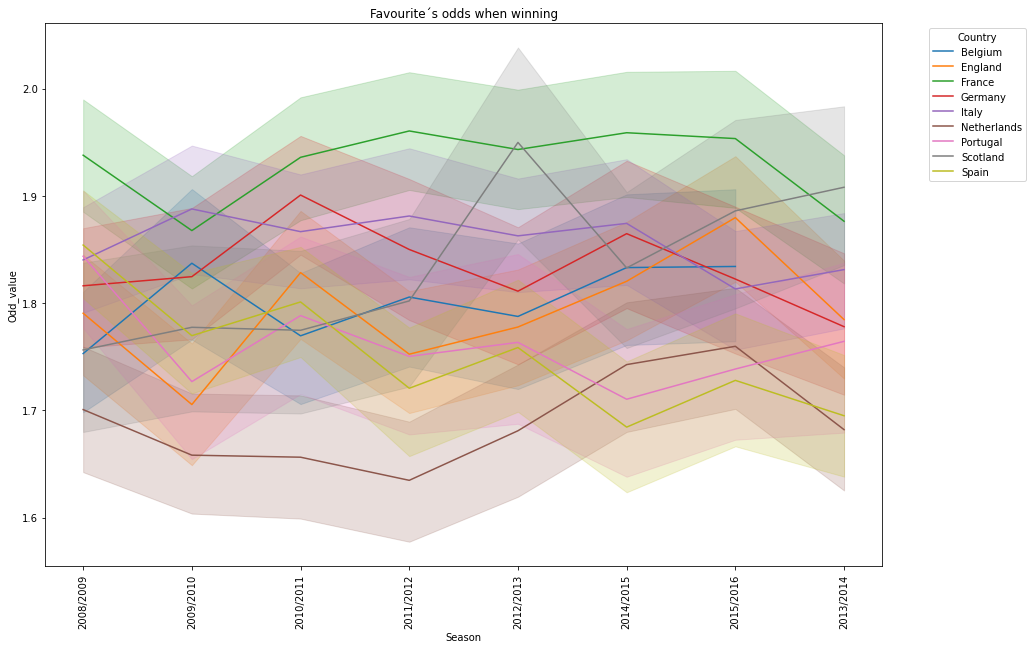

In [497]:
plt.figure(figsize=(15,10))
ax=sb.lineplot(x="season", y='fav_odd', hue="country", markers=True, data=df_statsv)
plt.xlabel('Season')
plt.ylabel('Odd_value')
plt.title('Favourite´s odds when winning')
plt.xticks(rotation=90)
ax.legend(title = 'Country', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
plt.show();

Now we have made a visualization to see the development of the victories of the favourite team related to
the betting odd depending on the country and the season.

In [498]:
df_stats=pd.DataFrame({'percent' : df_stats.groupby(['country','season']).favourite.value_counts(normalize = True)}).reset_index()
df_stats.head()

,country,season,favourite,percent
0,Belgium,2008/2009,Favourite_won,0.537954
1,Belgium,2008/2009,Non_favourite_won,0.244224
2,Belgium,2008/2009,No_winner,0.217822
3,Belgium,2009/2010,Favourite_won,0.547619
4,Belgium,2009/2010,No_winner,0.242857


In [499]:
df_statsf=df_stats[df_stats['favourite']=='Favourite_won']
df_statsf.head()

,country,season,favourite,percent
0,Belgium,2008/2009,Favourite_won,0.537954
3,Belgium,2009/2010,Favourite_won,0.547619
6,Belgium,2010/2011,Favourite_won,0.529167
9,Belgium,2011/2012,Favourite_won,0.558824
12,Belgium,2012/2013,Favourite_won,0.485106


In [500]:
df_statsnf=df_stats[df_stats['favourite']=='Non_favourite_won']
df_statsnf.head()

,country,season,favourite,percent
1,Belgium,2008/2009,Non_favourite_won,0.244224
5,Belgium,2009/2010,Non_favourite_won,0.209524
8,Belgium,2010/2011,Non_favourite_won,0.212500
11,Belgium,2011/2012,Non_favourite_won,0.168067
13,Belgium,2012/2013,Non_favourite_won,0.268085


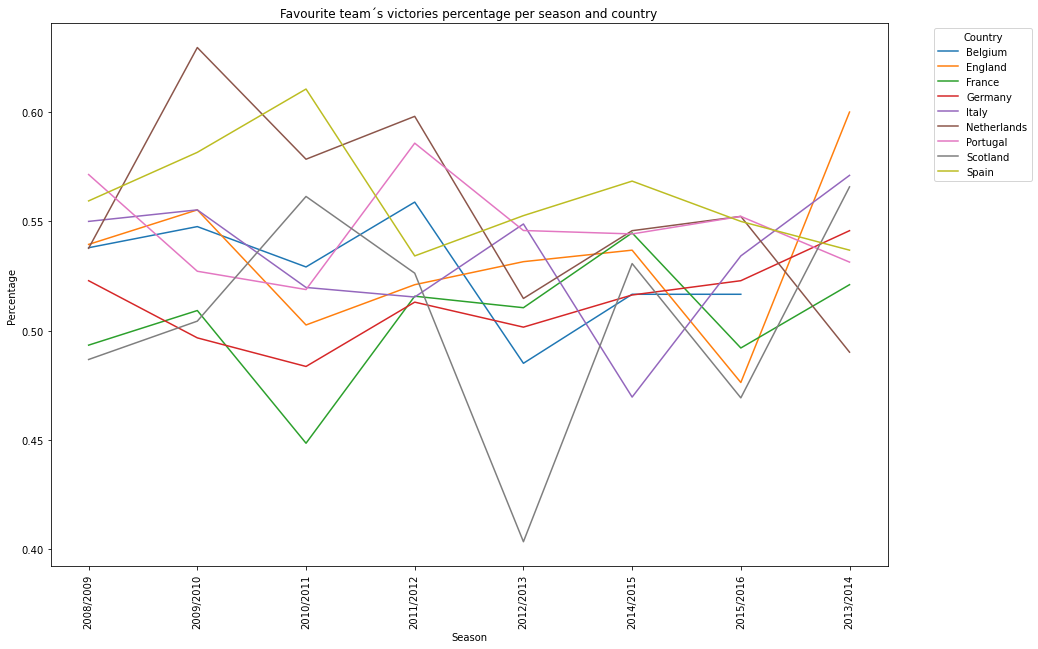

In [501]:
plt.figure(figsize=(15,10))
ax=sb.lineplot(x="season", y='percent', hue="country", markers=True, data=df_statsf)
plt.xlabel('Season')
plt.ylabel('Percentage')
plt.title('Favourite team´s victories percentage per season and country')
plt.xticks(rotation=90)
ax.legend(title = 'Country', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
plt.show();
# Ordenar fechas

In [502]:
plt.figure(figsize=(15,10))
ax=sb.lineplot(x="season", y='percent', hue="country", markers=True, data=df_statsnf)
plt.xlabel('Season')
plt.ylabel('Percentage')
plt.title(Favourite´s odds when winning)
plt.xticks(rotation=90)
ax.legend(title = 'Country', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
plt.show();


SyntaxError: invalid character in identifier (<ipython-input-502-219c51e1dfdb>, line 5)

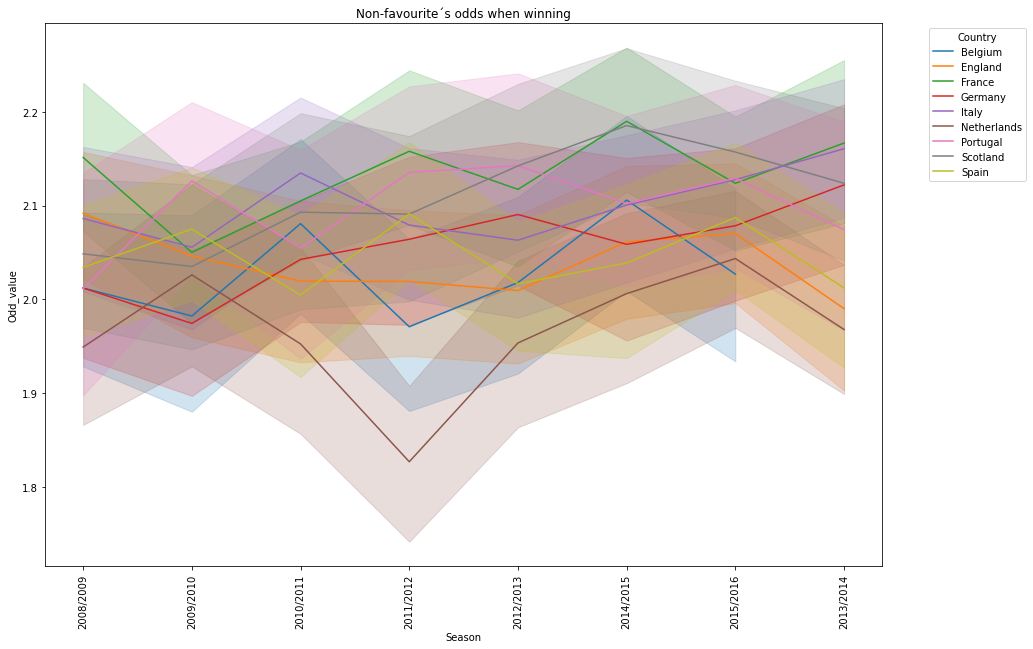

In [503]:
plt.figure(figsize=(15,10))
ax=sb.lineplot(x="season", y='fav_odd', hue="country", markers=True, data=df_statsd)
plt.xlabel('Season')
plt.ylabel('Odd_value')
plt.title('Non-favourite´s odds when winning')
plt.xticks(rotation=90)
ax.legend(title = 'Country', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
plt.show();


Now we have made a visualization to see the development of the victories of the non-favourite team related to
the betting odd depending on the country and season.

<a id='conclusions'></a>
## Conclusions

After plotting and making some calculations we can state that local teams win more matches than the teams that play away. Locals win 45.9% of the games, away teams 28.8% of the games and 25.3% of the games are even.
If we check it by countries, Spain is the country were more local victories take place, Scotland has the highest even rates and the French teams had the highest percentage for away victories.

Regarding the betting odds, we have determined that the teams with the lowest betting odd were the favourite teams and those with the highest betting odd were the non-favourite ones. It has been calculated that the 53.2% of the favourite teams won their games, as the non-favourites won just the 21.5%, while the even matches keep being 25.3%. Spain was the country where most percentage of games won the favourite team (56.17%) and where the non-favourite won the least (20.63%), so Spain is the country where the games´ results are most predictable. The mean betting odd for favourite teams is about 1.8 while for non-favourite teams is 4.05.

The mean goal difference when a favourite team wins as a local is 1.97 and when the victory is away the difference is 1.89. On the other hand, for non-favourite teams, the goal difference is bigger when winning away (1.54) and 1.52 when winnin at home, which is a non expected result because the results are expected to be better when playing as local. The country with the more goal difference is Netherlands in all cases (favourite/non-favourite and visit/local).

Regarding the last four graphics ('Favourite´s odds when winning', 'Non favourite´s odds when winning', 'Favourite´s odds when winning' and 'Non-avourite´s odds when winning') we can say that the trend is that the betting odd values decrease when the victories amount decrease. However we can find some exceptions like in Belgium (2009/10) for the favourite victories, where we can find a peak in the betting odd value and in the favourite teams´ victories percentage. It happened the same for Germany (2010/11) for non-favourite team, where there is a peak of victories and an increase in the betting odd value.